In [1]:
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 20)

In [2]:
def extract_results_from_file(prefix, benchmark_path):
    with open(benchmark_path) as f:
        run = json.load(f)
    results = []
    for b in run["benchmarks"]:
        name, random_seed_str, site_count_str = b["name"].split("/")
        name = prefix + "_".join(name.split("_")[:-1])
        seed = int(random_seed_str)
        site_count = int(site_count_str)
        real_time = float(b["real_time"])
        results.append((name, site_count, seed, real_time))
    return results

In [3]:
benchmark_files_by_prefix = {
    "laptop_": "benchmark_laptop.json",
    "desktop_": "benchmark_desktop.json",
}
results = [
    extract_results_from_file(prefix, "../data/" + filename)
    for prefix, filename in benchmark_files_by_prefix.items()
]
# flatten
results = [x for xs in results for x in xs]

In [4]:
data = pd.DataFrame(results, columns=["algo", "site_count", "seed", "ms"])
data.sample(n=20)

,algo,site_count,seed,ms
800,desktop_ping_pong,9,105,15.591109
848,desktop_ping_pong,12,108,38.529917
642,desktop_boost,13,112,308.765703
86,laptop_boost,6,111,23.740039
140,laptop_boost,10,105,645.624436
680,desktop_ping_pong,1,105,0.009860
828,desktop_ping_pong,11,103,30.634723
462,desktop_boost,1,112,0.033365
839,desktop_ping_pong,11,114,32.169579
681,desktop_ping_pong,1,106,0.009861


In [5]:
data.groupby("algo").ms.mean()

algo
desktop_boost         402.924136
desktop_ping_pong      51.395881
laptop_boost         1121.059250
laptop_ping_pong      104.155810
Name: ms, dtype: float64

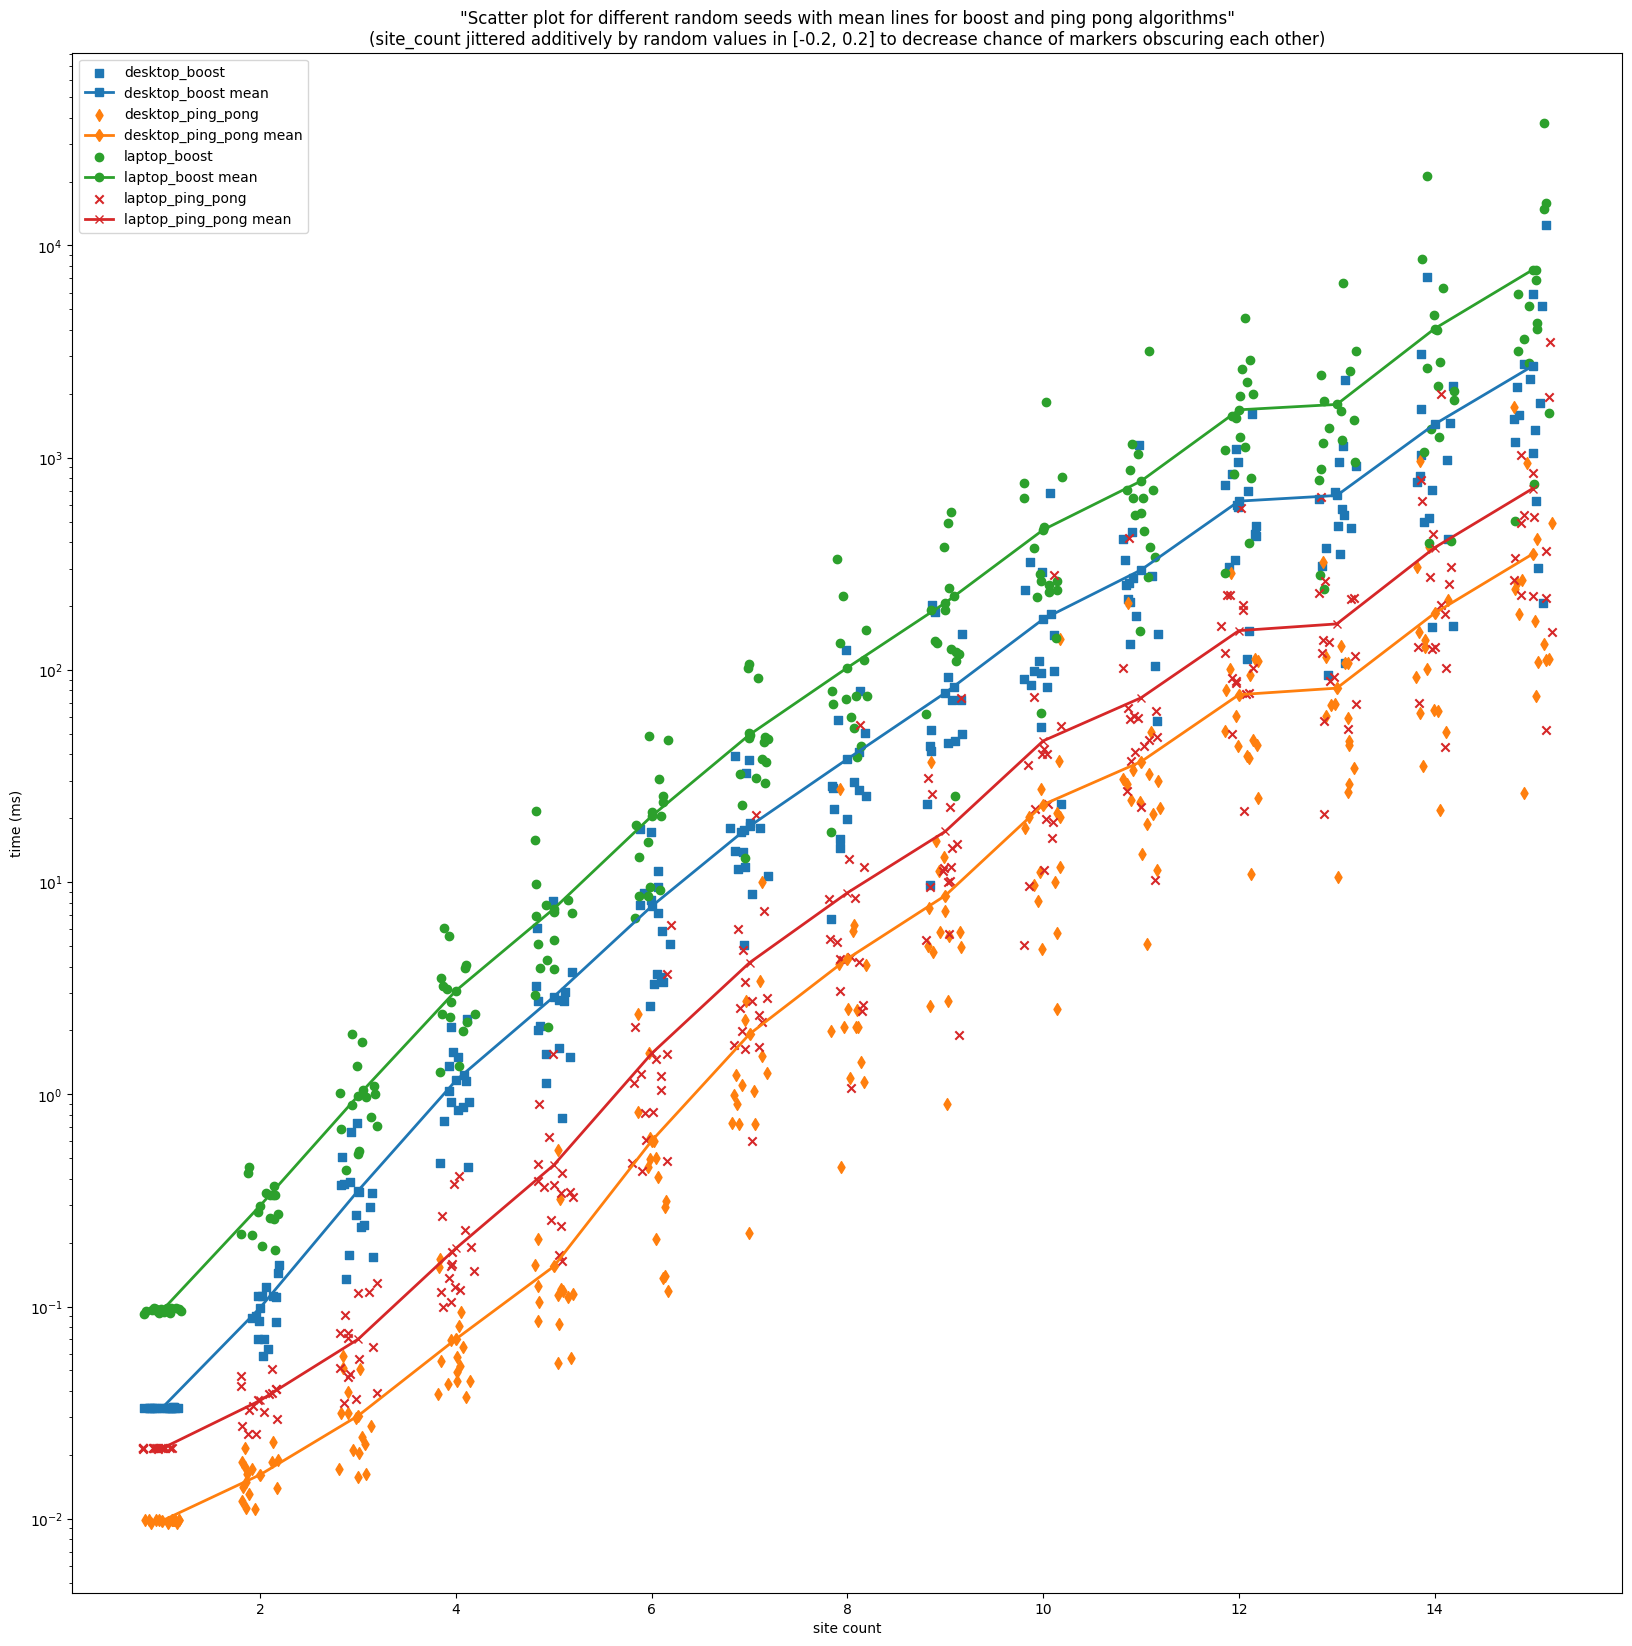

In [6]:
colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
markers = ["o", "x", "s", "d", "^", "v", "<", ">", "P", "*"]
algo2marker = {algo: marker for algo, marker in zip(data["algo"].unique(), markers)}
fig, ax = plt.subplots()
rng = np.random.default_rng(seed=42)

for algo, group in data.groupby("algo"):
    color = next(colors)
    for i, (seed, g) in enumerate(group.groupby("seed")):
        jitter_value = 0.2
        jittered_site_count = g["site_count"] + rng.uniform(
            -jitter_value, jitter_value, g["site_count"].shape[0]
        )
        ax.scatter(
            jittered_site_count,
            g["ms"],
            color=color,
            marker=algo2marker[algo],
            label=algo if i == 0 else None,  # only label once
        )

    mean_vals = group.groupby("site_count")["ms"].mean()
    ax.plot(
        mean_vals.index,
        mean_vals.values,
        color=color,
        marker=algo2marker[algo],
        linestyle="-",
        linewidth=2,
        label=f"{algo} mean",
    )

ax.set_xlabel("site count")
ax.set_yscale("log")
ax.set_ylabel("time (ms)")
title = f""""Scatter plot for different random seeds with mean lines for boost and ping pong algorithms"
(site_count jittered additively by random values in [-{jitter_value}, {jitter_value}] to decrease chance of markers obscuring each other)"""
ax.set_title(title)
ax.legend()

In [7]:
def plot_speed_up(ax, data, denominator_column, numerator_column):
    pivoted = (
        data[data.algo.isin([denominator_column, numerator_column])]
        .pivot_table(index=["seed", "site_count"], columns="algo", values="ms")
        .reset_index()
    )
    pivoted["rel_diff"] = pivoted[numerator_column] / pivoted[denominator_column]
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for seed, group in pivoted.groupby("seed"):
        color = next(colors)
        ax.scatter(
            group["site_count"],
            group["rel_diff"],
            marker="x",
            # label=f"seed {seed}",
            color=color,
        )

    rel_diff_described = pivoted.groupby("site_count").rel_diff.describe().reset_index()
    ax.plot(
        rel_diff_described["site_count"],
        rel_diff_described["mean"],
        marker="o",
        linestyle="-",
        label="mean over seeds",
        color="black",
    )
    ax.plot(
        rel_diff_described["site_count"],
        rel_diff_described["50%"],
        marker="o",
        linestyle="-",
        label="median over seeds",
        color="red",
    )

    ax.set_title(
        f"Speed Up ({denominator_column} over {numerator_column} for various seeds"
    )
    ax.set_xlabel("Site Count")
    ax.set_ylabel(f"{numerator_column} (ms) / {denominator_column} (ms)")
    ax.legend()

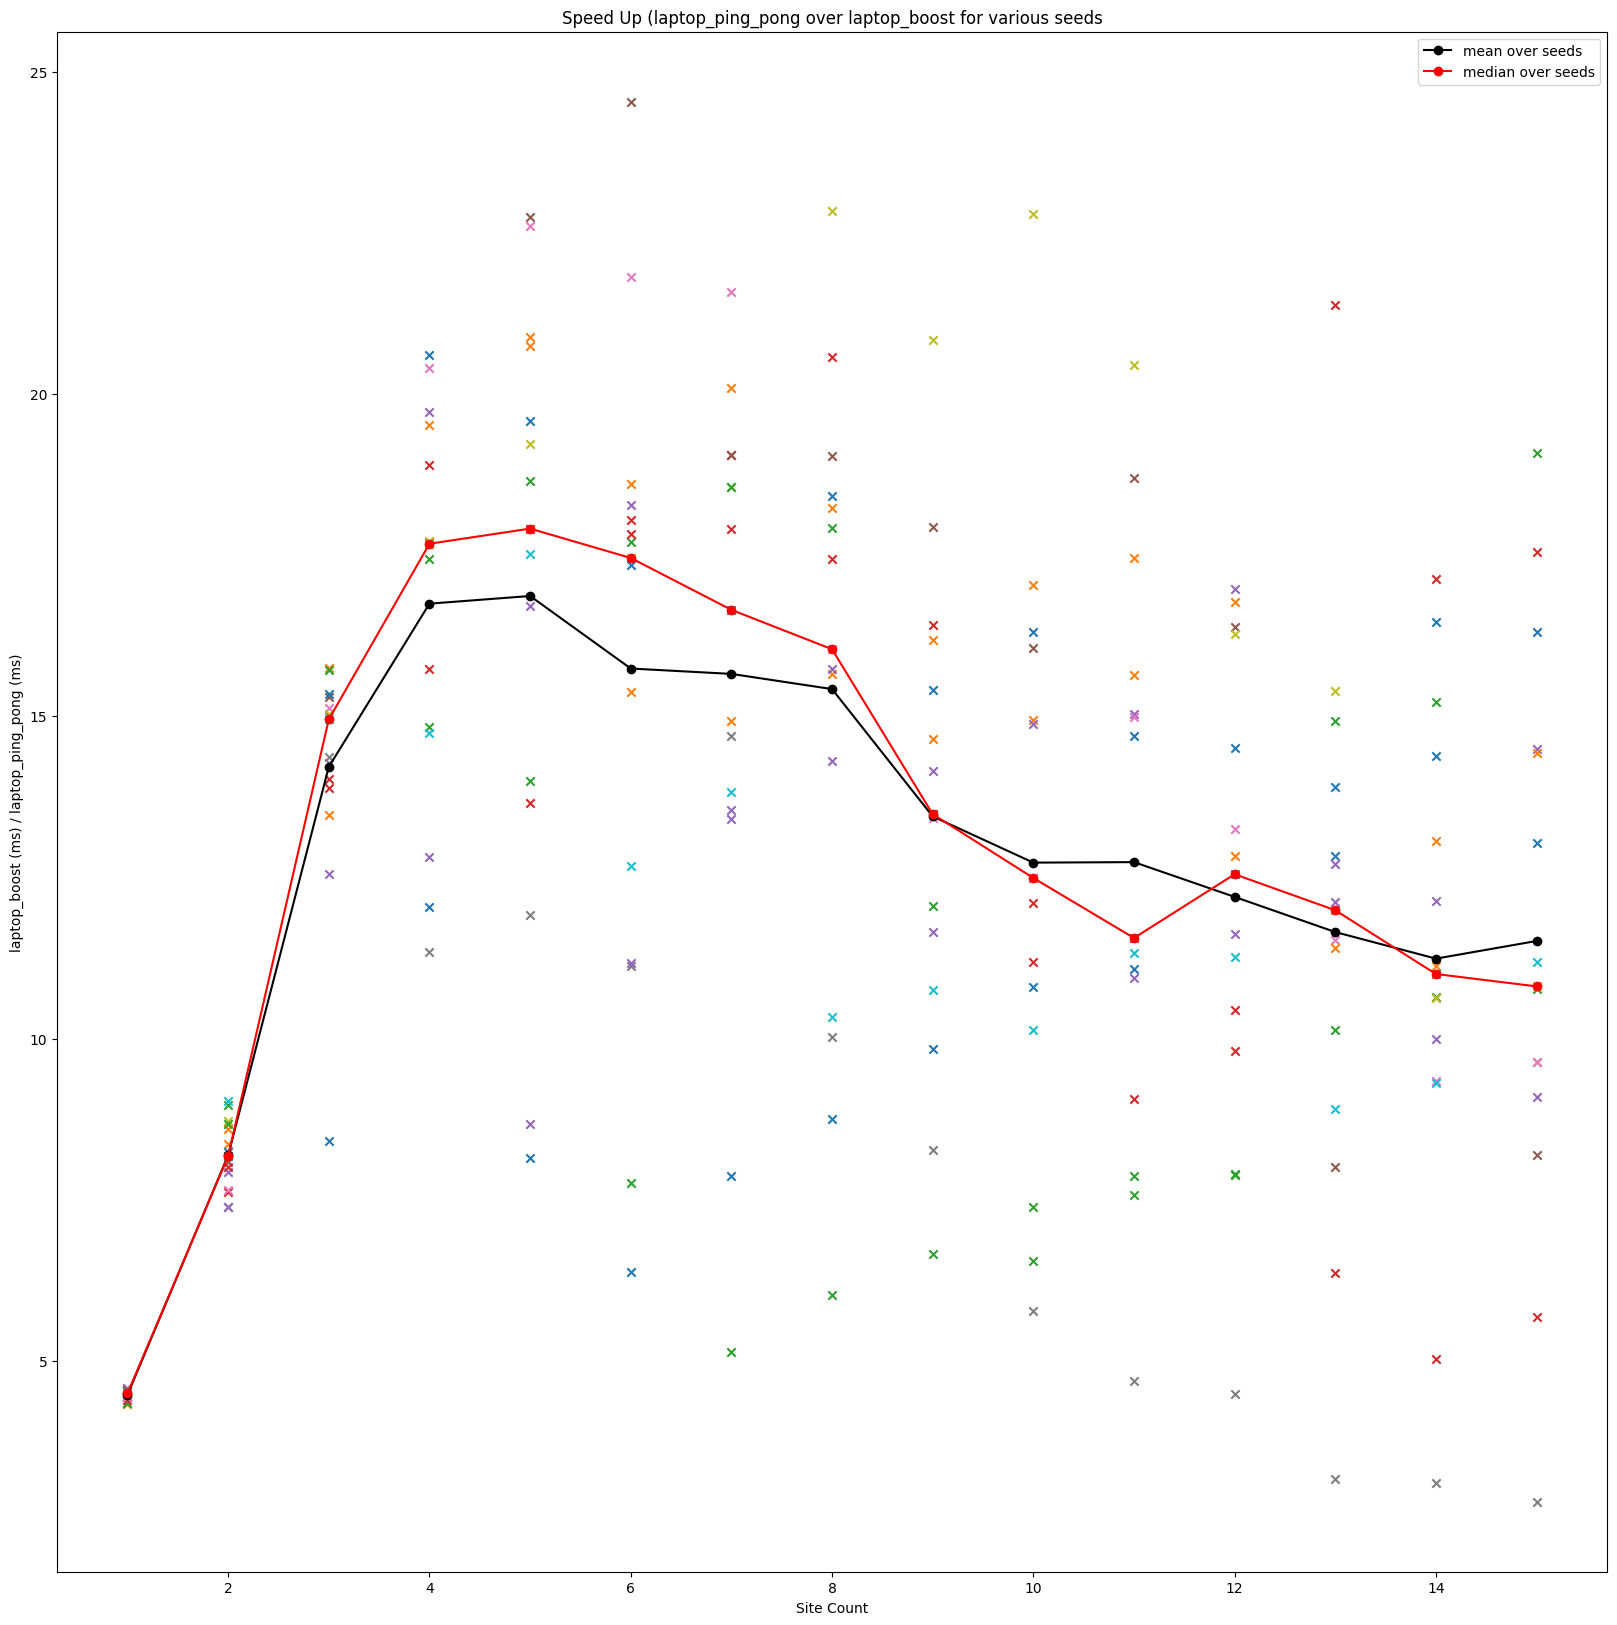

In [8]:
fig, ax = plt.subplots()
plot_speed_up(ax, data, "laptop_ping_pong", "laptop_boost")

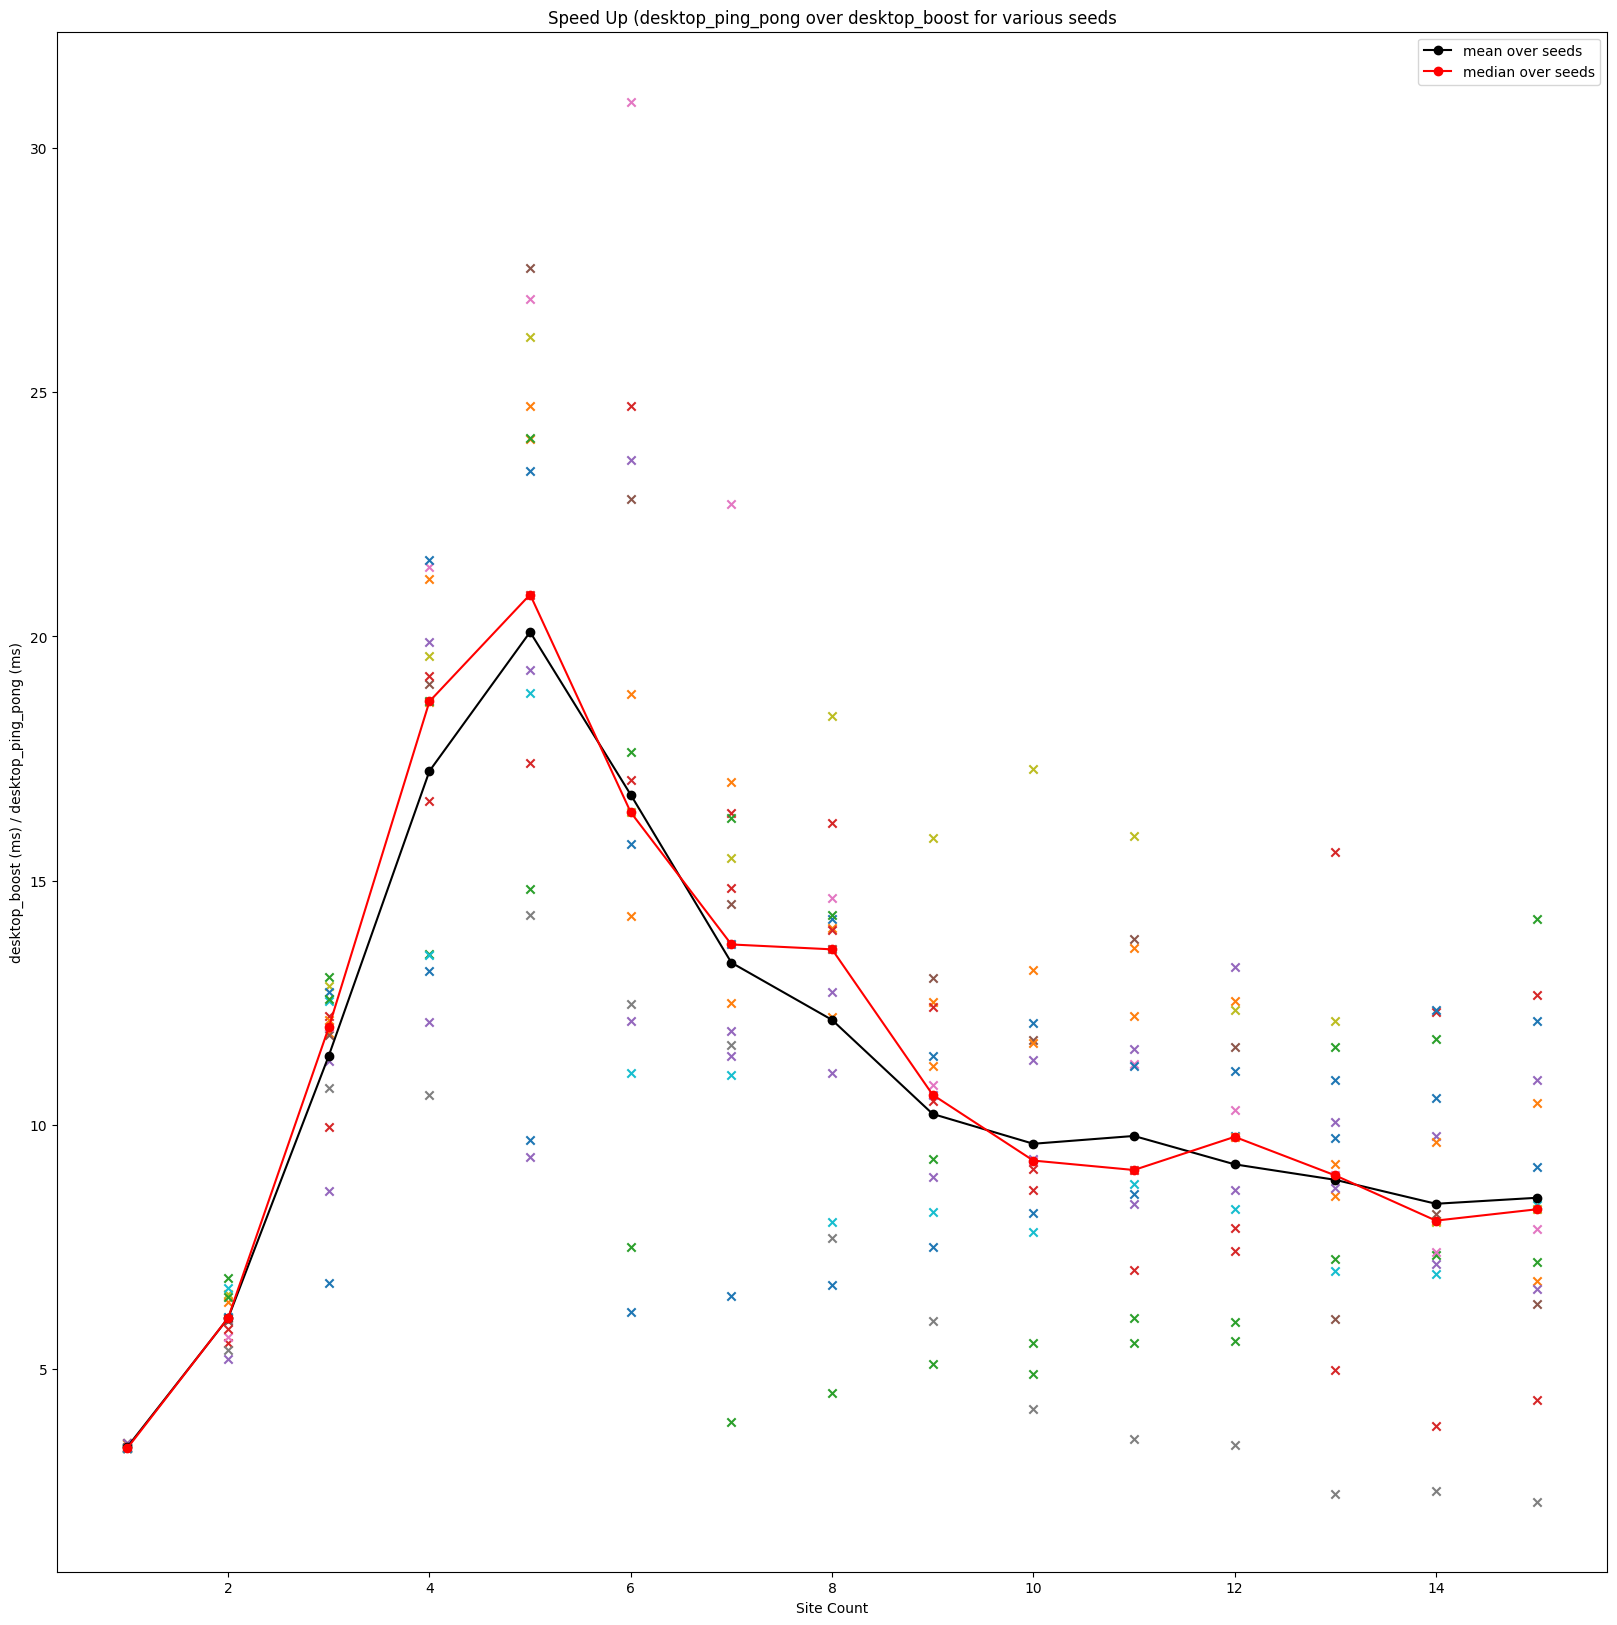

In [9]:
fig, ax = plt.subplots()
plot_speed_up(ax, data, "desktop_ping_pong", "desktop_boost")